## Import libraries
## Functions to read files which are in differnt format(pdf,.docx,.txt)
## Extract priority skills from the JD
## Filter CV based on MNC experience and institution
## Extract relevant skills from CV based on JD skills
## Function to extract years of experience from the CV text
## Score the CV based on skill matches, MNC experience, institution, and experience
## RFM-like scoring based on experience, skills, MNCs, and institutions
## Compute similarity score using TF-IDF and use cosine similarity function
## Apply weighted scoring with normalization and find weighted sum of the normalized scores

# Full code with exporting the result to .csv file

In [12]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from PyPDF2 import PdfReader
from docx import Document
from docx.opc.exceptions import PackageNotFoundError  # Importing the exception
import re

# Utility function to read the reference data files
def load_filter_file(file_path):
    with open(file_path, 'r') as file:
        return [line.strip() for line in file.readlines()]

# Define functions to read different file formats (PDF, DOCX, TXT)
def read_pdf(file_path):
    with open(file_path, 'rb') as f:
        reader = PdfReader(f)
        return " ".join([page.extract_text() for page in reader.pages if page.extract_text()])

def read_docx(file_path):
    doc = Document(file_path)
    return "\n".join([para.text for para in doc.paragraphs])

def read_txt_with_fallback(file_path):
    encodings = ['utf-8', 'latin-1', 'windows-1252']
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as f:
                return f.read()
        except UnicodeDecodeError:
            continue
    raise ValueError(f"Unable to decode the file: {file_path}")

def read_file_with_fallback(file_path):
    if file_path.endswith('.pdf'):
        return read_pdf(file_path)
    elif file_path.endswith('.docx'):
        return read_docx(file_path)
    elif file_path.endswith('.txt'):
        return read_txt_with_fallback(file_path)
    else:
        raise ValueError(f"Unsupported file format: {file_path}")

# Function to read CV as plain text if .docx reading fails
def read_cv_as_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()

# # Extract priority skills from the JD
# def extract_priority_skills(jd_text, skill_files):
#     """Extract priority skills from the JD based on predefined lists."""
#     skills = []
#     for skill_file in skill_files:
#         skills += load_filter_file(skill_file)  # Load each skill list
#     priority_skills = [skill for skill in skills if skill in jd_text]
#     return priority_skills
def extract_priority_skills(jd_text, skill_files):
    skills = []
    for skill_file in skill_files:
        skills += load_filter_file(skill_file)
    # Use a set to remove duplicates from the priority skills
    priority_skills = list(set([skill for skill in skills if skill in jd_text]))
    return priority_skills

# Filter CV based on MNC experience and institution
def filter_based_on_mnc_and_institution(cv_text, mnc_file, inst_files):
    mnc_list = load_filter_file(mnc_file)
    institution_lists = [load_filter_file(inst_file) for inst_file in inst_files]

    mnc_match = any(mnc in cv_text for mnc in mnc_list)
    institution_match = any(inst in cv_text for inst_list in institution_lists for inst in inst_list)
    
    return mnc_match, institution_match

# Extract relevant skills from CV based on JD skills
def extract_cv_details(cv_text, jd_skills):
    cv_skills = jd_skills  # Assuming CV skills are a subset of JD skills
    matched_skills = [skill for skill in cv_skills if skill in cv_text]
    return matched_skills

# Function to extract years of experience from the CV text
def extract_years_of_experience(cv_text):
    # Updated regex to account for both integer and decimal years
    experience_matches = re.findall(r'(\d+\.?\d*)\+?\s*years?\s*(of\s*experience)?', cv_text)

    # If matches found, return the maximum number of years mentioned
    if experience_matches:
        # Convert all matches to floats to handle both integer and decimal years
        return max(float(years) for years, _ in experience_matches)
    else:
        return 0  # Default to 0 if no experience is found
    

# Score the CV based on skill matches, MNC experience, institution, and experience
def score_cv(matched_skills, mnc_match, institution_match, years_of_experience):
    score = len(matched_skills) * 10  # 10 points per matched skill
    if mnc_match:
        score += 20  # Bonus for MNC experience
    if institution_match:
        score += 15  # Bonus for top-tier institution
    score += years_of_experience * 2  # Add 2 points per year of experience
    return score

# RFM-like scoring based on experience, skills, MNCs, and institutions
def compute_rfm_score(matched_skills, mnc_match, institution_match, years_of_experience):
    # Recency: Score for recent experience
    recency_score = years_of_experience  # Assuming recent experience is beneficial
    
    # Frequency: Score based on the number of skills matched
    frequency_score = len(matched_skills)
    
    # Monetary: Score based on MNC experience and institution prestige
    monetary_score = 0
    if mnc_match:
        monetary_score += 15  # Score for MNC experience
    if institution_match:
        monetary_score += 10  # Score for prestigious institutions

    # Final RFM score combining all components
    return recency_score + frequency_score + monetary_score

# Compute similarity score using TF-IDF
def compute_similarity(jd_text, cv_text):
    vectorizer = TfidfVectorizer()
    texts = [jd_text, cv_text]
    tfidf_matrix = vectorizer.fit_transform(texts)
    similarity_matrix = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
    return similarity_matrix[0][0]

# Apply weighted scoring and normalization
def compute_weighted_score(similarity_score, skill_match_score, rfm_score, similarity_weight=0.6, skill_weight=0.4, rfm_weight=0.4):
    # Normalize both scores to be between 0 and 1
    normalized_similarity = similarity_score / 1.0  # Cosine similarity is already between 0 and 1
    normalized_skill_match = skill_match_score / 100  # Assuming the max skill match score is 100
    normalized_rfm = rfm_score / 100  # Assuming the max RFM score is 100
    
    # Weighted sum of the normalized scores
    weighted_score = (similarity_weight * normalized_similarity) + \
                     (skill_weight * normalized_skill_match) + \
                     (rfm_weight * normalized_rfm)
    return weighted_score

# Paths for JD, CV, and reference data files
jd_path = 'Dataset/job_descriptions/'
cv_path = 'Dataset/resumes/'
ref_data_path = 'ReferenceData/'

# Skill and filter files
skill_files = [os.path.join(ref_data_path, f) for f in ['library.txt', 'global_skill.txt', 'skillset.txt']]
inst_files = [os.path.join(ref_data_path, f) for f in ['INST.txt', 'tier1.txt', 'tier2.txt']]
mnc_file = os.path.join(ref_data_path, 'mnc.txt')

# List available job descriptions
jd_filenames = [filename for filename in os.listdir(jd_path) if filename.endswith(('.txt', '.pdf', '.docx'))]
print("Available Job Descriptions:")
for jd_filename in jd_filenames:
    print(f"- {jd_filename}")

# Prompt user to select a JD
selected_jd_filename = input("Enter the name of the Job Description file you want to analyze: ")

# Check if the selected JD exists
if selected_jd_filename not in jd_filenames:
    print("The specified Job Description file does not exist. Please check the name and try again.")
else:
    # Read the selected JD text
    jd_text = read_file_with_fallback(os.path.join(jd_path, selected_jd_filename))

    # Extract JD skills
    jd_skills = extract_priority_skills(jd_text, skill_files)

    # Initialize a list to store results for the selected JD
    results = []

    # Process CVs
    for cv_filename in os.listdir(cv_path):
        if cv_filename.endswith(('.txt', '.pdf', '.docx')):
            full_cv_path = os.path.join(cv_path, cv_filename)
            print(f"Processing file: {full_cv_path}")

            try:
                print(f"Attempting to read: {full_cv_path}")  # Added for debugging
                cv_text = read_file_with_fallback(full_cv_path)

                # Compute similarity score
                similarity_score = compute_similarity(jd_text, cv_text)
                similarity_score = round(similarity_score, 2)

                # Extract CV skills and perform MNC and institution filtering
                matched_skills = extract_cv_details(cv_text, jd_skills)
                mnc_match, institution_match = filter_based_on_mnc_and_institution(cv_text, mnc_file, inst_files)
                years_of_experience = extract_years_of_experience(cv_text)

                # Score the CV based on skills matched
                skill_match_score = len(matched_skills) * 10  # 10 points for each matched skill
                rfm_score = compute_rfm_score(matched_skills, mnc_match, institution_match, years_of_experience)

                # Print RFM Scores
                print(f"RFM Scores for {cv_filename}:")
                print(f"  - Recency Score: {years_of_experience}")
                print(f"  - Frequency Score: {len(matched_skills)}")
                print(f"  - Monetary Score: {15 if mnc_match else 0 + 10 if institution_match else 0}")

                # Compute weighted score
                weighted_score = compute_weighted_score(similarity_score, skill_match_score, rfm_score)
                weighted_score = round(weighted_score, 2)

                # Store results
                results.append({
                    'JD Filename': selected_jd_filename,
                    'CV Filename': cv_filename,
                    'Similarity Score': similarity_score,
                    'Skill Match Score': skill_match_score,
                    'RFM Score': rfm_score,
                    'Weighted Score': weighted_score,
                    'Years of Experience': years_of_experience,
                    'Matched Skills': matched_skills,
                    'MNC Match': mnc_match,
                    'Institution Match': institution_match
                })

            except Exception as e:
                print(f"Failed to process {cv_filename}: {e}")

    # # Create DataFrame and save results to CSV
    # results_df = pd.DataFrame(results)
    # results_df.to_csv('cv_scoring_results.csv', index=False)
    # print("Results have been saved to 'cv_scoring_results.csv'")

    # Create DataFrame and save results to CSV
    results_df = pd.DataFrame(results)

    # Sort the DataFrame by Weighted Score in descending order
    #results_df.sort_values(by='Weighted Score', ascending=False, inplace=True)
    # Sort by 'Weighted Score' and 'Years of Experience' in descending order (reverse=True in your list-based example)
    results_df.sort_values(by=['Weighted Score', 'Years of Experience'], ascending=[False, False], inplace=True)

    # Assign ranks based on the sorted order
    results_df['Rank'] = range(1, len(results_df) + 1)

    # Resetting the index and dropping the old index column
    results_df.reset_index(drop=True, inplace=True)

    # Printing the DataFrame with the "Rank" column at the beginning
    results_df_with_rank = results_df[['Rank'] + [col for col in results_df.columns if col != 'Rank']]



     # Save the sorted results to CSV
    results_df.to_csv('cv_scoring_results_new.csv', index=False)
    print("Results have been saved to 'cv_scoring_results_new.csv'")



Available Job Descriptions:
- architect.docx
- CKA Engineer.docx
- Devops Engineer.docx
- java developer.docx
- R-1151.docx
- R-1180.docx
- R-18721.docx
- R-23010.docx
- R-23564.docx
- R-23570.docx
- R-23673.docx
- R-24689.docx


Enter the name of the Job Description file you want to analyze:  Devops Engineer.docx


Processing file: Dataset/resumes/Abhilash Subudhi.pdf
Attempting to read: Dataset/resumes/Abhilash Subudhi.pdf
RFM Scores for Abhilash Subudhi.pdf:
  - Recency Score: 8.8
  - Frequency Score: 5
  - Monetary Score: 15
Processing file: Dataset/resumes/Abhishek.pdf
Attempting to read: Dataset/resumes/Abhishek.pdf
RFM Scores for Abhishek.pdf:
  - Recency Score: 3.0
  - Frequency Score: 5
  - Monetary Score: 15
Processing file: Dataset/resumes/Anil Kumar.docx
Attempting to read: Dataset/resumes/Anil Kumar.docx
RFM Scores for Anil Kumar.docx:
  - Recency Score: 2.4
  - Frequency Score: 0
  - Monetary Score: 15
Processing file: Dataset/resumes/ANKITA.docx
Attempting to read: Dataset/resumes/ANKITA.docx
RFM Scores for ANKITA.docx:
  - Recency Score: 3.0
  - Frequency Score: 6
  - Monetary Score: 15
Processing file: Dataset/resumes/AradhanaTripathi.docx
Attempting to read: Dataset/resumes/AradhanaTripathi.docx
RFM Scores for AradhanaTripathi.docx:
  - Recency Score: 4.0
  - Frequency Score: 2
 

## CV similarity scores with labels(as per threshold) exported to 'cv_similarity_labels.xlsx'

In [16]:
import os
import fitz  # PyMuPDF for PDF parsing
import docx  # python-docx for DOCX parsing
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

# Function to extract text from PDF files
def extract_text_from_pdf(file_path):
    text = ""
    with fitz.open(file_path) as doc:
        for page in doc:
            text += page.get_text()
    return text

# Function to extract text from DOCX files
def extract_text_from_docx(file_path):
    doc = docx.Document(file_path)
    text = "\n".join([para.text for para in doc.paragraphs])
    return text

# Function to handle both PDF and DOCX files
def extract_text_from_file(file_path):
    if file_path.endswith('.pdf'):
        return extract_text_from_pdf(file_path)
    elif file_path.endswith('.docx'):
        return extract_text_from_docx(file_path)
    else:
        raise ValueError("Unsupported file format. Only PDF and DOCX are supported.")

# Define the paths for CVs and job descriptions
cv_path = 'Dataset/resumes/'
jd_path = 'Dataset/job_descriptions/'

# Step 1: Load all CV files from the specified directory into a DataFrame
cv_files = [f for f in os.listdir(cv_path) if f.endswith(('.pdf', '.docx'))]

# Load CV data by extracting text from each CV file
cv_data_frames = []
for file in cv_files:
    file_path = os.path.join(cv_path, file)
    content = extract_text_from_file(file_path)
    cv_data_frames.append(pd.DataFrame({'filename': [file], 'content': [content]}))

# Combine all CVs into a single DataFrame
if cv_data_frames:
    cv_data = pd.concat(cv_data_frames, ignore_index=True)
else:
    raise ValueError("No valid CV files to concatenate")

# List all job description files in the specified JD directory
jd_filenames = [f for f in os.listdir(jd_path) if f.endswith('.txt') or f.endswith('.docx') or f.endswith('.pdf')]

# Display available job descriptions
print("Available Job Descriptions:")
for jd_filename in jd_filenames:
    print(f"- {jd_filename}")

# Prompt user to select a JD
selected_jd_filename = input("Enter the name of the Job Description file you want to analyze: ")

# Build the full path of the selected JD file
selected_jd_path = os.path.join(jd_path, selected_jd_filename)

# Load the content of the selected JD file based on its format
selected_jd_text = ""
if selected_jd_filename.endswith('.txt'):
    with open(selected_jd_path, 'r', encoding='ISO-8859-1') as jd_file:
        selected_jd_text = jd_file.read()
elif selected_jd_filename.endswith('.docx'):
    selected_jd_text = extract_text_from_docx(selected_jd_path)
elif selected_jd_filename.endswith('.pdf'):
    selected_jd_text = extract_text_from_pdf(selected_jd_path)

# Print the content of the selected JD file (for verification)
print("\nSelected Job Description Content:\n")
print(selected_jd_text)

# Step 4: Preprocess CV and JD text using TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Combine JD and CV data for vectorization
documents = [selected_jd_text] + cv_data['content'].tolist()

# Fit and transform text data
X = vectorizer.fit_transform(documents)

# Calculate similarity scores as a weighted score for each CV
similarity_scores = X[1:, :].dot(X[0, :].T).A.flatten()  # Dot product to get similarity scores for CVs

# Set a threshold for determining positive labels
threshold = 0.08  # Adjust this threshold based on your needs

# Step 5: Define the target labels dynamically based on the threshold
y = [1 if score >= threshold else 0 for score in similarity_scores]

# Check for consistency between X and y
if len(y) != X.shape[0] - 1:
    raise ValueError(f"Mismatch between number of samples in X ({X.shape[0]}) and y ({len(y)})")

# Display similarity scores and labels for verification
for filename, score in zip(cv_data['filename'], similarity_scores):
    print(f"CV: {filename}, Similarity Score: {score:.4f}, Label: {1 if score >= threshold else 0}")

# Step 6: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X[1:, :], y, test_size=0.2, random_state=42)  # Only CVs for X

# Step 7: Train a classification model (e.g., Naive Bayes)
model = MultinomialNB()
model.fit(X_train, y_train)

# Step 8: Predict the labels for all CVs
y_all_pred = model.predict(X[1:, :])  # Predict for all CVs

# Step 9: Generate confusion matrix and classification report
conf_matrix_all = confusion_matrix(y, y_all_pred)
class_report_all = classification_report(y, y_all_pred, zero_division=1)

# Calculate TP, TN, FP, FN for all predictions
TP_all = conf_matrix_all[1, 1] if len(conf_matrix_all) > 1 and conf_matrix_all.shape[1] > 1 else 0  # True Positives
TN_all = conf_matrix_all[0, 0] if len(conf_matrix_all) > 0 and conf_matrix_all.shape[0] > 0 else 0  # True Negatives
FP_all = conf_matrix_all[0, 1] if len(conf_matrix_all) > 0 and conf_matrix_all.shape[1] > 1 else 0  # False Positives
FN_all = conf_matrix_all[1, 0] if len(conf_matrix_all) > 1 and conf_matrix_all.shape[0] > 1 else 0  # False Negatives

# Calculate accuracy and precision for all predictions
accuracy_all = (TP_all + TN_all) / (TP_all + TN_all + FP_all + FN_all) if (TP_all + TN_all + FP_all + FN_all) > 0 else 0
precision_all = TP_all / (TP_all + FP_all) if (TP_all + FP_all) > 0 else 0

# Step 10: Display the results for all predictions
print("Predictions Confusion Matrix:")
print(conf_matrix_all)

print("\nPredictions Classification Report:")
print(class_report_all)

print("\nPredictions Metrics:")
print(f"True Positives (TP): {TP_all}")
print(f"True Negatives (TN): {TN_all}")
print(f"False Positives (FP): {FP_all}")
print(f"False Negatives (FN): {FN_all}")
print(f"Accuracy: {accuracy_all:.2f}")
print(f"Precision: {precision_all:.2f}")

# # Repeat the predictions for all 1s
# y_all_pred_ones = [1] * len(y)  # All predictions as 1
# conf_matrix_ones = confusion_matrix(y, y_all_pred_ones)
# class_report_ones = classification_report(y, y_all_pred_ones, zero_division=1)

# # Calculate TP, TN, FP, FN for all predictions as 1
# TP_ones = conf_matrix_ones[1, 1] if len(conf_matrix_ones) > 1 and conf_matrix_ones.shape[1] > 1 else 0
# TN_ones = conf_matrix_ones[0, 0] if len(conf_matrix_ones) > 0 and conf_matrix_ones.shape[0] > 0 else 0
# FP_ones = conf_matrix_ones[0, 1] if len(conf_matrix_ones) > 0 and conf_matrix_ones.shape[1] > 1 else 0
# FN_ones = conf_matrix_ones[1, 0] if len(conf_matrix_ones) > 1 and conf_matrix_ones.shape[0] > 1 else 0

# # Calculate accuracy and precision for all predictions as 1
# accuracy_ones = (TP_ones + TN_ones) / (TP_ones + TN_ones + FP_ones + FN_ones) if (TP_ones + TN_ones + FP_ones + FN_ones) > 0 else 0
# precision_ones = TP_ones / (TP_ones + FP_ones) if (TP_ones + FP_ones) > 0 else 0

# # Step 11: Display results for all predictions as 1
# print("\nAll Predictions as 1 Confusion Matrix:")
# print(conf_matrix_ones)

# print("\nAll Predictions as 1 Classification Report:")
# print(class_report_ones)

# print("\nAll Predictions as 1 Metrics:")
# print(f"True Positives (TP): {TP_ones}")
# print(f"True Negatives (TN): {TN_ones}")
# print(f"False Positives (FP): {FP_ones}")
# print(f"False Negatives (FN): {FN_ones}")
# print(f"Accuracy: {accuracy_ones:.2f}")
# print(f"Precision: {precision_ones:.2f}")

# # Repeat the predictions for all 0s
# y_all_pred_zeros = [0] * len(y)  # All predictions as 0
# conf_matrix_zeros = confusion_matrix(y, y_all_pred_zeros)
# class_report_zeros = classification_report(y, y_all_pred_zeros, zero_division=1)

# # Calculate TP, TN, FP, FN for all predictions as 0
# TP_zeros = conf_matrix_zeros[1, 1] if len(conf_matrix_zeros) > 1 and conf_matrix_zeros.shape[1] > 1 else 0
# TN_zeros = conf_matrix_zeros[0, 0] if len(conf_matrix_zeros) > 0 and conf_matrix_zeros.shape[0] > 0 else 0
# FP_zeros = conf_matrix_zeros[0, 1] if len(conf_matrix_zeros) > 0 and conf_matrix_zeros.shape[1] > 1 else 0
# FN_zeros = conf_matrix_zeros[1, 0] if len(conf_matrix_zeros) > 1 and conf_matrix_zeros.shape[0] > 1 else 0

# # Calculate accuracy and precision for all predictions as 0
# accuracy_zeros = (TP_zeros + TN_zeros) / (TP_zeros + TN_zeros + FP_zeros + FN_zeros) if (TP_zeros + TN_zeros + FP_zeros + FN_zeros) > 0 else 0
# precision_zeros = TP_zeros / (TP_zeros + FP_zeros) if (TP_zeros + FP_zeros) > 0 else 0

# # Step 12: Display results for all predictions as 0
# print("\nAll Predictions as 0 Confusion Matrix:")
# print(conf_matrix_zeros)

# print("\nAll Predictions as 0 Classification Report:")
# print(class_report_zeros)

# print("\nAll Predictions as 0 Metrics:")
# print(f"True Positives (TP): {TP_zeros}")
# print(f"True Negatives (TN): {TN_zeros}")
# print(f"False Positives (FP): {FP_zeros}")
# print(f"False Negatives (FN): {FN_zeros}")
# print(f"Accuracy: {accuracy_zeros:.2f}")
# print(f"Precision: {precision_zeros:.2f}")

# Step 11: Export CVs with labels to Excel
output_df = pd.DataFrame({
    'filename': cv_data['filename'],
    'similarity_score': similarity_scores,
    'predicted_label': y_all_pred
})

output_df.to_excel('cv_similarity_labels.xlsx', index=False)
print("\nCV similarity scores and labels exported to 'cv_similarity_labels.xlsx'")


Available Job Descriptions:
- architect.docx
- CKA Engineer.docx
- Devops Engineer.docx
- java developer.docx
- R-1151.docx
- R-1180.docx
- R-18721.docx
- R-23010.docx
- R-23564.docx
- R-23570.docx
- R-23673.docx
- R-24689.docx


Enter the name of the Job Description file you want to analyze:  Devops Engineer.docx



Selected Job Description Content:

Job Title: DevOps Engineer
Location: Remote / On-site
Experience Level: 3+ Years
Job Description:
We are seeking a DevOps Engineer to help us automate and streamline our operations and processes. You will be responsible for deploying product updates, identifying production issues, and implementing integrations that meet our customers' needs.
Responsibilities:
Collaborate with software developers and IT staff to manage code releases.
Build and maintain tools for deployment, monitoring, and operations.
Automate and improve development and release processes.
Troubleshoot and resolve issues in development, test, and production environments.
Ensure security, scalability, and high availability of our infrastructure.
Required Skills:
Strong experience with AWS, Azure, or Google Cloud platforms.
Proficiency in Docker and Kubernetes.
Experience with continuous integration and continuous delivery (CI/CD) tools like Jenkins, GitLab, or CircleCI.
Strong scriptin

In [6]:
# Code 2

In [18]:
import os
import fitz  # PyMuPDF for PDF parsing
import docx  # python-docx for DOCX parsing
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

# Function to extract text from PDF files
def extract_text_from_pdf(file_path):
    text = ""
    with fitz.open(file_path) as doc:
        for page in doc:
            text += page.get_text()
    return text

# Function to extract text from DOCX files
def extract_text_from_docx(file_path):
    doc = docx.Document(file_path)
    text = "\n".join([para.text for para in doc.paragraphs])
    return text

# Function to handle both PDF and DOCX files
def extract_text_from_file(file_path):
    if file_path.endswith('.pdf'):
        return extract_text_from_pdf(file_path)
    elif file_path.endswith('.docx'):
        return extract_text_from_docx(file_path)
    else:
        raise ValueError("Unsupported file format. Only PDF and DOCX are supported.")

# Define the paths for CVs and job descriptions
cv_path = 'Dataset/resumes/'
jd_path = 'Dataset/job_descriptions/'

# Step 1: Load all CV files from the specified directory into a DataFrame
cv_files = [f for f in os.listdir(cv_path) if f.endswith(('.pdf', '.docx'))]

# Load CV data by extracting text from each CV file
cv_data_frames = []
for file in cv_files:
    file_path = os.path.join(cv_path, file)
    content = extract_text_from_file(file_path)
    cv_data_frames.append(pd.DataFrame({'filename': [file], 'content': [content]}))

# Combine all CVs into a single DataFrame
if cv_data_frames:
    cv_data = pd.concat(cv_data_frames, ignore_index=True)
else:
    raise ValueError("No valid CV files to concatenate")

# List all job description files in the specified JD directory
jd_filenames = [f for f in os.listdir(jd_path) if f.endswith('.txt') or f.endswith('.docx') or f.endswith('.pdf')]

# Display available job descriptions
print("Available Job Descriptions:")
for jd_filename in jd_filenames:
    print(f"- {jd_filename}")

# Prompt user to select a JD
selected_jd_filename = input("Enter the name of the Job Description file you want to analyze: ")

# Build the full path of the selected JD file
selected_jd_path = os.path.join(jd_path, selected_jd_filename)

# Load the content of the selected JD file based on its format
selected_jd_text = ""
if selected_jd_filename.endswith('.txt'):
    with open(selected_jd_path, 'r', encoding='ISO-8859-1') as jd_file:
        selected_jd_text = jd_file.read()
elif selected_jd_filename.endswith('.docx'):
    selected_jd_text = extract_text_from_docx(selected_jd_path)
elif selected_jd_filename.endswith('.pdf'):
    selected_jd_text = extract_text_from_pdf(selected_jd_path)

# Print the content of the selected JD file (for verification)
print("\nSelected Job Description Content:\n")
print(selected_jd_text)

# Step 4: Preprocess CV and JD text using TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Combine JD and CV data for vectorization
documents = [selected_jd_text] + cv_data['content'].tolist()

# Fit and transform text data
X = vectorizer.fit_transform(documents)

# Calculate similarity scores as a weighted score for each CV
similarity_scores = X[1:, :].dot(X[0, :].T).A.flatten()  # Dot product to get similarity scores for CVs

# Set a threshold for determining positive labels
threshold = 0.08  # Adjust this threshold based on your needs

# Step 5: Define the target labels dynamically based on the threshold
y = [1 if score >= threshold else 0 for score in similarity_scores]

# Check for consistency between X and y
if len(y) != X.shape[0] - 1:
    raise ValueError(f"Mismatch between number of samples in X ({X.shape[0]}) and y ({len(y)})")

# Display similarity scores and labels for verification
for filename, score in zip(cv_data['filename'], similarity_scores):
    print(f"CV: {filename}, Similarity Score: {score:.4f}, Label: {1 if score >= threshold else 0}")

# Step 6: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X[1:, :], y, test_size=0.2, random_state=42)  # Only CVs for X

# Step 7: Train a classification model (e.g., Naive Bayes)
model = MultinomialNB()
model.fit(X_train, y_train)

# Step 8: Predict the labels for all CVs
y_all_pred = model.predict(X[1:, :])  # Predict for all CVs

# Step 9: Generate confusion matrix and classification report
conf_matrix_all = confusion_matrix(y, y_all_pred)
class_report_all = classification_report(y, y_all_pred, zero_division=1)

# Calculate TP, TN, FP, FN for all predictions
TP_all = conf_matrix_all[1, 1] if len(conf_matrix_all) > 1 and conf_matrix_all.shape[1] > 1 else 0  # True Positives
TN_all = conf_matrix_all[0, 0] if len(conf_matrix_all) > 0 and conf_matrix_all.shape[0] > 0 else 0  # True Negatives
FP_all = conf_matrix_all[0, 1] if len(conf_matrix_all) > 0 and conf_matrix_all.shape[1] > 1 else 0  # False Positives
FN_all = conf_matrix_all[1, 0] if len(conf_matrix_all) > 1 and conf_matrix_all.shape[0] > 1 else 0  # False Negatives

# Calculate accuracy and precision for all predictions
accuracy_all = (TP_all + TN_all) / (TP_all + TN_all + FP_all + FN_all) if (TP_all + TN_all + FP_all + FN_all) > 0 else 0
precision_all = TP_all / (TP_all + FP_all) if (TP_all + FP_all) > 0 else 0

# Step 10: Display the results for all predictions
print("Predictions Confusion Matrix:")
print(conf_matrix_all)

print("\nPredictions Classification Report:")
print(class_report_all)

print("\nPredictions Metrics:")
print(f"True Positives (TP): {TP_all}")
print(f"True Negatives (TN): {TN_all}")
print(f"False Positives (FP): {FP_all}")
print(f"False Negatives (FN): {FN_all}")
print(f"Accuracy: {accuracy_all:.2f}")
print(f"Precision: {precision_all:.2f}")

# # Repeat the predictions for all 1s
# y_all_pred_ones = [1] * len(y)  # All predictions as 1
# conf_matrix_ones = confusion_matrix(y, y_all_pred_ones)
# class_report_ones = classification_report(y, y_all_pred_ones, zero_division=1)

# # Calculate TP, TN, FP, FN for all predictions as 1
# TP_ones = conf_matrix_ones[1, 1] if len(conf_matrix_ones) > 1 and conf_matrix_ones.shape[1] > 1 else 0
# TN_ones = conf_matrix_ones[0, 0] if len(conf_matrix_ones) > 0 and conf_matrix_ones.shape[0] > 0 else 0
# FP_ones = conf_matrix_ones[0, 1] if len(conf_matrix_ones) > 0 and conf_matrix_ones.shape[1] > 1 else 0
# FN_ones = conf_matrix_ones[1, 0] if len(conf_matrix_ones) > 1 and conf_matrix_ones.shape[0] > 1 else 0

# # Calculate accuracy and precision for all predictions as 1
# accuracy_ones = (TP_ones + TN_ones) / (TP_ones + TN_ones + FP_ones + FN_ones) if (TP_ones + TN_ones + FP_ones + FN_ones) > 0 else 0
# precision_ones = TP_ones / (TP_ones + FP_ones) if (TP_ones + FP_ones) > 0 else 0

# # Step 11: Display results for all predictions as 1
# print("\nAll Predictions as 1 Confusion Matrix:")
# print(conf_matrix_ones)

# print("\nAll Predictions as 1 Classification Report:")
# print(class_report_ones)

# print("\nAll Predictions as 1 Metrics:")
# print(f"True Positives (TP): {TP_ones}")
# print(f"True Negatives (TN): {TN_ones}")
# print(f"False Positives (FP): {FP_ones}")
# print(f"False Negatives (FN): {FN_ones}")
# print(f"Accuracy: {accuracy_ones:.2f}")
# print(f"Precision: {precision_ones:.2f}")

# # Repeat the predictions for all 0s
# y_all_pred_zeros = [0] * len(y)  # All predictions as 0
# conf_matrix_zeros = confusion_matrix(y, y_all_pred_zeros)
# class_report_zeros = classification_report(y, y_all_pred_zeros, zero_division=1)

# # Calculate TP, TN, FP, FN for all predictions as 0
# TP_zeros = conf_matrix_zeros[1, 1] if len(conf_matrix_zeros) > 1 and conf_matrix_zeros.shape[1] > 1 else 0
# TN_zeros = conf_matrix_zeros[0, 0] if len(conf_matrix_zeros) > 0 and conf_matrix_zeros.shape[0] > 0 else 0
# FP_zeros = conf_matrix_zeros[0, 1] if len(conf_matrix_zeros) > 0 and conf_matrix_zeros.shape[1] > 1 else 0
# FN_zeros = conf_matrix_zeros[1, 0] if len(conf_matrix_zeros) > 1 and conf_matrix_zeros.shape[0] > 1 else 0

# # Calculate accuracy and precision for all predictions as 0
# accuracy_zeros = (TP_zeros + TN_zeros) / (TP_zeros + TN_zeros + FP_zeros + FN_zeros) if (TP_zeros + TN_zeros + FP_zeros + FN_zeros) > 0 else 0
# precision_zeros = TP_zeros / (TP_zeros + FP_zeros) if (TP_zeros + FP_zeros) > 0 else 0

# # Step 12: Display results for all predictions as 0
# print("\nAll Predictions as 0 Confusion Matrix:")
# print(conf_matrix_zeros)

# print("\nAll Predictions as 0 Classification Report:")
# print(class_report_zeros)

# print("\nAll Predictions as 0 Metrics:")
# print(f"True Positives (TP): {TP_zeros}")
# print(f"True Negatives (TN): {TN_zeros}")
# print(f"False Positives (FP): {FP_zeros}")
# print(f"False Negatives (FN): {FN_zeros}")
# print(f"Accuracy: {accuracy_zeros:.2f}")
# print(f"Precision: {precision_zeros:.2f}")


Available Job Descriptions:
- architect.docx
- CKA Engineer.docx
- Devops Engineer.docx
- java developer.docx
- R-1151.docx
- R-1180.docx
- R-18721.docx
- R-23010.docx
- R-23564.docx
- R-23570.docx
- R-23673.docx
- R-24689.docx


Enter the name of the Job Description file you want to analyze:  Devops Engineer.docx



Selected Job Description Content:

Job Title: DevOps Engineer
Location: Remote / On-site
Experience Level: 3+ Years
Job Description:
We are seeking a DevOps Engineer to help us automate and streamline our operations and processes. You will be responsible for deploying product updates, identifying production issues, and implementing integrations that meet our customers' needs.
Responsibilities:
Collaborate with software developers and IT staff to manage code releases.
Build and maintain tools for deployment, monitoring, and operations.
Automate and improve development and release processes.
Troubleshoot and resolve issues in development, test, and production environments.
Ensure security, scalability, and high availability of our infrastructure.
Required Skills:
Strong experience with AWS, Azure, or Google Cloud platforms.
Proficiency in Docker and Kubernetes.
Experience with continuous integration and continuous delivery (CI/CD) tools like Jenkins, GitLab, or CircleCI.
Strong scriptin

# confusion matrix heat map

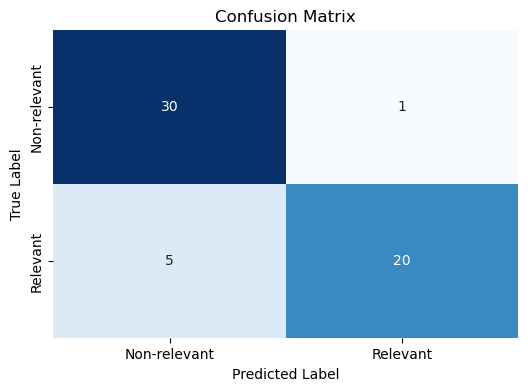

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 9: Generate confusion matrix and classification report
conf_matrix_all = confusion_matrix(y, y_all_pred)
class_report_all = classification_report(y, y_all_pred, zero_division=1)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_all, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Non-relevant', 'Relevant'], yticklabels=['Non-relevant', 'Relevant'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Continue with calculating TP, TN, FP, FN for all predictions as before
TP_all = conf_matrix_all[1, 1] if len(conf_matrix_all) > 1 and conf_matrix_all.shape[1] > 1 else 0  # True Positives
TN_all = conf_matrix_all[0, 0] if len(conf_matrix_all) > 0 and conf_matrix_all.shape[0] > 0 else 0  # True Negatives
FP_all = conf_matrix_all[0, 1] if len(conf_matrix_all) > 0 and conf_matrix_all.shape[1] > 1 else 0  # False Positives
FN_all = conf_matrix_all[1, 0] if len(conf_matrix_all) > 1 and conf_matrix_all.shape[0] > 1 else 0  # False Negatives

# Continue with the rest of the metrics calculation and reporting


## Summary:
### Data Cleaning: Handles reading and processing files (PDF, DOCX, TXT) and cleaning the data.
### Value Segmentation: Extracts and segments relevant data such as skills from JD and CV, computes similarity scores, and filters based on certain criteria (MNC, institution).
### Data Modelling: Computes various scores (skill match, RFM, weighted score) to model the relationship between the JD and CV based on the extracted features.